# Tutorial on self-normalizing networks on the MNIST data set: multi-layer perceptrons

*Author:* Kajetan Schweighofer, 2021

In [1]:
import os
import copy
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


# load data and preprocess

path = os.path.join(".", "dataset", "mnist")
os.makedirs(path, exist_ok=True)

# convert PIL image to tensor and normalize
transform = transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train = torchvision.datasets.MNIST(path, download=True, train=True, transform=transform)
test = torchvision.datasets.MNIST(path, download=True, train=False, transform=transform)

## Functions

### Model

In [2]:

    
class ExpActivation(nn.Module):
    """
    Applies elementwise activation based on exponential function

    Inspired by squared relu, but with bounded range and gradient for better stability
    """
    def __init__(self):
        super(ExpActivation, self).__init__()

    def forward(self, input):
        # print("using exponential activation")
        return torch.exp(input)

class ReEUActivation(nn.Module):
    """
    Applies elementwise activation based on rectified exponential unit function
    f(x) = exp(x) if x > 0 else 0
    """
    def __init__(self):
        super(ReEUActivation, self).__init__()

    def forward(self, input):
        return torch.exp(nn.functional.relu(input)) - 1.0
    
    
class SoftmaxActivation(nn.Module):
    """
    Applies the Softmax activation function elementwise
    """
    def __init__(self):
        super(SoftmaxActivation, self).__init__()

    def forward(self, input):
        return nn.functional.softmax(input, dim=-1)
    
    

In [3]:
class MLP(nn.Module):

    def __init__(self, in_features: int, out_features: int, p_drop=0.2, act_fn: str="relu"):
        super(MLP, self).__init__()

        if act_fn == "selu":
            activation = nn.SELU()
        elif act_fn == "relu":
            activation = nn.ReLU()
        elif act_fn == "exp":
            activation = ExpActivation()
        elif act_fn == "softmax":
            activation = SoftmaxActivation()
        elif act_fn == "reu":
            activation = ReEUActivation()
        elif act_fn == "elu":
            activation = nn.ELU()
        else:
            raise ValueError(f"Unsupported activation function: {act_fn}")
        # activation = nn.SELU() if act_fn == "selu" else nn.ReLU()
        # dropout = nn.AlphaDropout(p=p_drop) if act_fn == "selu" else nn.Dropout(p=p_drop) # use standard dropout for all activations
        dropout = nn.Dropout(p=p_drop)
        self.net = nn.Sequential(
            nn.Flatten(),   # flatten input image from batchx1x28x28 to batchx784
            nn.Linear(in_features=in_features, out_features=1024),
            activation,
            dropout,
            nn.Linear(in_features=1024, out_features=512),
            activation,
            dropout,
            nn.Linear(in_features=512, out_features=out_features)
        )

        if act_fn == "selu":
            for param in self.net.parameters():
                # biases zero
                if len(param.shape) == 1:
                    nn.init.constant_(param, 0)
                # others using lecun-normal initialization
                else:
                    nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='linear')

    def forward(self, x):
        return self.net(x)

### Accuracy metric

In [4]:
class Accuracy(nn.Module):

    def forward(self, x, y):

        y_pred = F.softmax(x, dim=1).argmax(dim=1).cpu().numpy()
        y = y.cpu().numpy()

        return accuracy_score(y_true=y, y_pred=y_pred)

### Training / Evaluation methods

In [5]:
def _forward(network: nn.Module, data: DataLoader, metric: callable):

    for x, y in data:
        x = x.to(next(network.parameters()).device)

        # y_hat = network.forward(x)
        y_hat = network.forward(x).cpu()
        loss = metric(y_hat, y)
        yield loss

@torch.enable_grad()
def update(network: nn.Module, data: DataLoader, loss: nn.Module,
           opt: torch.optim.Optimizer) -> list:

    network.train()

    errs = []
    for err in _forward(network, data, loss):
        errs.append(err.item())
        opt.zero_grad()
        try:
            err.backward()
            opt.step()
        except:
            print('error in update step')
    return errs

@torch.no_grad()
def evaluate(network: nn.Module, data: DataLoader, metric: callable) -> float:

    network.eval()

    performance = []
    for p in _forward(network, data, metric):
        p = np.array(p)
        performance.append(p.item())
    return np.mean(performance).item()


def fit(network: nn.Module, trainloader: DataLoader, valloader: DataLoader,
          testloader: DataLoader, epochs: int, lr: float):
    optimizer = torch.optim.SGD(params=network.parameters(), lr=lr)
    ce = nn.CrossEntropyLoss()
    accuracy = Accuracy()

    train_losses, val_losses, accuracies = [], [], []

    # performance before training
    val_losses.append(evaluate(network=network, data=valloader, metric=ce))

    pbar = tqdm(range(epochs))
    for ep in pbar:
        # update network
        tl = update(network=network, data=trainloader, loss=ce, opt=optimizer)
        train_losses.extend(tl)
        vl = evaluate(network=network, data=valloader, metric=ce)
        val_losses.append(vl)
        ac = evaluate(network=network, data=valloader, metric=accuracy)

        if len(accuracies) == 0 or ac > max(accuracies):
            # here we would store the model on disc for early stopping
            best_model = copy.deepcopy(network)

        accuracies.append(ac)

        print(f"train loss: {round(np.mean(tl), 4):.4f}, "
              f"val loss: {round(vl, 4):.4f}, "
              f"accuracy: {round(ac * 100, 2):.2f}%")

        pbar.set_description_str(desc=f"Epoch {ep+1}")

    # evaluate on best model obtained throughout training
    acc = evaluate(network=best_model, data=testloader, metric=accuracy)

    print(f"Final accuracy on testset: {round(acc*100, 2):.2f}%")

    return train_losses, val_losses, accuracies, acc

## Training

### Hyperparameters

In [6]:
epochs = 20
lr = 1e-3
batch_size = 128
num_workers = 4
p_drop = 0.05

### Create Dataloaders

In [7]:
# obtain validation set (1/6 of train data to be equal to size of test data)
rng = np.random.default_rng(seed=42)
val_inds = rng.choice(np.arange(len(train)), size=len(train)//6, replace=False)
train_inds = np.delete(np.arange(len(train)), val_inds)

trainloader = DataLoader(Subset(train, indices=train_inds),
                         batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
valloader = DataLoader(Subset(train, indices=val_inds),
                       batch_size=batch_size, drop_last=True, shuffle=True, num_workers=num_workers)
testloader = DataLoader(test, batch_size=batch_size, drop_last=False, shuffle=False, num_workers=num_workers)

### Train Networks

In [14]:
# ReLU training

# 28x28 = 784 input images for 10 classes
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="relu").to(device)
rtl, rvl, raccs, racc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [01:15<23:54, 75.48s/it]

train loss: 2.1865, val loss: 2.0712, accuracy: 63.81%


Epoch 2:  10%|█         | 2/20 [02:38<24:03, 80.20s/it]

train loss: 1.9382, val loss: 1.7755, accuracy: 71.34%


Epoch 3:  15%|█▌        | 3/20 [03:50<21:38, 76.37s/it]

train loss: 1.6018, val loss: 1.4061, accuracy: 76.22%


Epoch 4:  20%|██        | 4/20 [05:09<20:39, 77.44s/it]

train loss: 1.2458, val loss: 1.0805, accuracy: 80.36%


Epoch 5:  25%|██▌       | 5/20 [06:27<19:23, 77.58s/it]

train loss: 0.9721, val loss: 0.8612, accuracy: 82.88%


Epoch 6:  30%|███       | 6/20 [06:41<13:02, 55.86s/it]

train loss: 0.7971, val loss: 0.7229, accuracy: 84.47%


Epoch 7:  35%|███▌      | 7/20 [07:22<11:02, 50.96s/it]

train loss: 0.6853, val loss: 0.6310, accuracy: 85.70%


Epoch 8:  40%|████      | 8/20 [08:30<11:16, 56.38s/it]

train loss: 0.6089, val loss: 0.5677, accuracy: 86.43%


Epoch 9:  45%|████▌     | 9/20 [09:43<11:17, 61.62s/it]

train loss: 0.5546, val loss: 0.5214, accuracy: 87.25%


Epoch 10:  50%|█████     | 10/20 [10:59<11:00, 66.03s/it]

train loss: 0.5142, val loss: 0.4860, accuracy: 87.80%


Epoch 11:  55%|█████▌    | 11/20 [12:12<10:13, 68.13s/it]

train loss: 0.4816, val loss: 0.4583, accuracy: 88.18%


Epoch 12:  60%|██████    | 12/20 [13:24<09:15, 69.39s/it]

train loss: 0.4569, val loss: 0.4357, accuracy: 88.45%


Epoch 13:  65%|██████▌   | 13/20 [14:41<08:21, 71.61s/it]

train loss: 0.4364, val loss: 0.4175, accuracy: 88.78%


Epoch 14:  70%|███████   | 14/20 [15:57<07:17, 72.93s/it]

train loss: 0.4190, val loss: 0.4038, accuracy: 89.03%


Epoch 15:  75%|███████▌  | 15/20 [17:14<06:10, 74.16s/it]

train loss: 0.4045, val loss: 0.3901, accuracy: 89.18%


Epoch 16:  80%|████████  | 16/20 [18:30<04:59, 74.80s/it]

train loss: 0.3922, val loss: 0.3789, accuracy: 89.48%


Epoch 17:  85%|████████▌ | 17/20 [19:44<03:43, 74.59s/it]

train loss: 0.3816, val loss: 0.3695, accuracy: 89.63%


Epoch 18:  90%|█████████ | 18/20 [21:06<02:33, 76.82s/it]

train loss: 0.3717, val loss: 0.3609, accuracy: 89.83%


Epoch 19:  95%|█████████▌| 19/20 [22:24<01:17, 77.14s/it]

train loss: 0.3636, val loss: 0.3536, accuracy: 90.02%


Epoch 20: 100%|██████████| 20/20 [23:41<00:00, 71.09s/it]

train loss: 0.3557, val loss: 0.3459, accuracy: 90.14%


Final accuracy on testset: 90.79%


In [9]:
# SELU training
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="selu").to(device)
stl, svl, saccs, sacc = fit(network, trainloader, valloader, testloader, epochs, lr)

  0%|          | 0/20 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1:   5%|▌         | 1/20 [00:13<04:08, 13.08s/it]

train loss: 0.9848, val loss: 0.5779, accuracy: 83.92%


Epoch 2:  10%|█         | 2/20 [00:26<03:56, 13.15s/it]

train loss: 0.5316, val loss: 0.4547, accuracy: 87.07%


Epoch 3:  15%|█▌        | 3/20 [00:39<03:44, 13.21s/it]

train loss: 0.4472, val loss: 0.4051, accuracy: 88.42%


Epoch 4:  20%|██        | 4/20 [00:52<03:31, 13.21s/it]

train loss: 0.4069, val loss: 0.3751, accuracy: 89.17%


Epoch 5:  25%|██▌       | 5/20 [01:06<03:20, 13.35s/it]

train loss: 0.3805, val loss: 0.3563, accuracy: 89.77%


Epoch 6:  30%|███       | 6/20 [01:19<03:06, 13.30s/it]

train loss: 0.3630, val loss: 0.3425, accuracy: 90.11%


Epoch 7:  35%|███▌      | 7/20 [01:33<02:55, 13.47s/it]

train loss: 0.3486, val loss: 0.3306, accuracy: 90.40%


Epoch 8:  40%|████      | 8/20 [01:46<02:41, 13.47s/it]

train loss: 0.3365, val loss: 0.3213, accuracy: 90.61%


Epoch 9:  45%|████▌     | 9/20 [02:00<02:29, 13.61s/it]

train loss: 0.3274, val loss: 0.3141, accuracy: 90.77%


Epoch 10:  50%|█████     | 10/20 [02:13<02:14, 13.45s/it]

train loss: 0.3189, val loss: 0.3077, accuracy: 90.89%


Epoch 11:  55%|█████▌    | 11/20 [02:27<02:01, 13.47s/it]

train loss: 0.3122, val loss: 0.3019, accuracy: 91.03%


Epoch 12:  60%|██████    | 12/20 [02:40<01:46, 13.32s/it]

train loss: 0.3058, val loss: 0.2973, accuracy: 91.24%


Epoch 13:  65%|██████▌   | 13/20 [02:53<01:33, 13.32s/it]

train loss: 0.3011, val loss: 0.2927, accuracy: 91.28%


Epoch 14:  70%|███████   | 14/20 [03:50<02:39, 26.57s/it]

train loss: 0.2959, val loss: 0.2876, accuracy: 91.47%


Epoch 15:  75%|███████▌  | 15/20 [05:02<03:20, 40.05s/it]

train loss: 0.2905, val loss: 0.2842, accuracy: 91.62%


Epoch 16:  80%|████████  | 16/20 [06:19<03:25, 51.29s/it]

train loss: 0.2861, val loss: 0.2812, accuracy: 91.65%


Epoch 17:  85%|████████▌ | 17/20 [07:42<03:02, 60.77s/it]

train loss: 0.2817, val loss: 0.2778, accuracy: 91.83%


Epoch 18:  90%|█████████ | 18/20 [09:02<02:13, 66.72s/it]

train loss: 0.2783, val loss: 0.2745, accuracy: 91.95%


Epoch 19:  95%|█████████▌| 19/20 [10:30<01:12, 72.94s/it]

train loss: 0.2749, val loss: 0.2715, accuracy: 92.04%


Epoch 20: 100%|██████████| 20/20 [11:50<00:00, 35.54s/it]

train loss: 0.2708, val loss: 0.2691, accuracy: 92.15%


Final accuracy on testset: 92.62%


In [10]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="exp").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

softtl, softvl, softaccs, softacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [01:26<27:25, 86.61s/it]

train loss: 0.8063, val loss: 0.4098, accuracy: 87.83%


Epoch 2:  10%|█         | 2/20 [02:49<25:16, 84.25s/it]

train loss: 0.4225, val loss: 0.3162, accuracy: 90.84%


Epoch 3:  15%|█▌        | 3/20 [04:11<23:40, 83.54s/it]

train loss: 0.3444, val loss: 0.2697, accuracy: 92.03%


Epoch 4:  20%|██        | 4/20 [05:39<22:42, 85.14s/it]

train loss: 0.3042, val loss: 0.2385, accuracy: 93.12%


Epoch 5:  25%|██▌       | 5/20 [07:01<20:57, 83.84s/it]

train loss: 0.2727, val loss: 0.2221, accuracy: 93.62%


Epoch 6:  30%|███       | 6/20 [08:28<19:51, 85.08s/it]

train loss: 0.2494, val loss: 0.2056, accuracy: 94.08%


Epoch 7:  35%|███▌      | 7/20 [09:51<18:16, 84.33s/it]

train loss: 0.2319, val loss: 0.1996, accuracy: 94.21%


Epoch 8:  40%|████      | 8/20 [11:07<16:22, 81.84s/it]

train loss: 0.2193, val loss: 0.1883, accuracy: 94.65%


Epoch 9:  45%|████▌     | 9/20 [12:24<14:41, 80.17s/it]

train loss: 0.2068, val loss: 0.1775, accuracy: 94.77%


Epoch 10:  50%|█████     | 10/20 [13:45<13:23, 80.33s/it]

train loss: 0.1937, val loss: 0.1718, accuracy: 95.26%


Epoch 11:  55%|█████▌    | 11/20 [14:59<11:46, 78.55s/it]

train loss: 0.1855, val loss: 0.1657, accuracy: 95.29%


Epoch 12:  60%|██████    | 12/20 [16:21<10:36, 79.54s/it]

train loss: 0.1776, val loss: 0.1566, accuracy: 95.53%


Epoch 13:  65%|██████▌   | 13/20 [17:36<09:06, 78.13s/it]

train loss: 0.1701, val loss: 0.1551, accuracy: 95.48%


Epoch 14:  70%|███████   | 14/20 [18:54<07:48, 78.09s/it]

train loss: 0.1621, val loss: 0.1529, accuracy: 95.59%


Epoch 15:  75%|███████▌  | 15/20 [20:12<06:30, 78.09s/it]

train loss: 0.1551, val loss: 0.1452, accuracy: 95.94%


Epoch 16:  80%|████████  | 16/20 [21:35<05:18, 79.63s/it]

train loss: 0.1496, val loss: 0.1429, accuracy: 96.01%


Epoch 17:  85%|████████▌ | 17/20 [22:55<03:59, 79.77s/it]

train loss: 0.1462, val loss: 0.1435, accuracy: 95.90%


Epoch 18:  90%|█████████ | 18/20 [24:15<02:39, 79.78s/it]

train loss: 0.1405, val loss: 0.1385, accuracy: 96.06%


Epoch 19:  95%|█████████▌| 19/20 [25:30<01:18, 78.26s/it]

train loss: 0.1347, val loss: 0.1341, accuracy: 96.16%


Epoch 20: 100%|██████████| 20/20 [26:55<00:00, 80.79s/it]

train loss: 0.1279, val loss: 0.1375, accuracy: 96.18%


Final accuracy on testset: 96.27%


In [11]:
# Softmax training
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="softmax").to(device)
network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="elu").to(device)
# network = MLP(in_features=784, out_features=10, p_drop=p_drop, act_fn="reu").to(device)

elutl, eluvl, eluaccs, eluacc = fit(network, trainloader, valloader, testloader, epochs, lr)

Epoch 1:   5%|▌         | 1/20 [02:34<49:01, 154.80s/it]

train loss: 1.9408, val loss: 1.6059, accuracy: 72.41%


Epoch 2:  10%|█         | 2/20 [05:10<46:33, 155.17s/it]

train loss: 1.3601, val loss: 1.1396, accuracy: 79.01%


Epoch 3:  15%|█▌        | 3/20 [07:47<44:15, 156.22s/it]

train loss: 0.9983, val loss: 0.8695, accuracy: 82.64%


Epoch 4:  20%|██        | 4/20 [10:18<41:07, 154.24s/it]

train loss: 0.7926, val loss: 0.7145, accuracy: 84.77%


Epoch 5:  25%|██▌       | 5/20 [12:46<37:57, 151.81s/it]

train loss: 0.6707, val loss: 0.6206, accuracy: 85.95%


Epoch 6:  30%|███       | 6/20 [13:59<29:13, 125.22s/it]

train loss: 0.5928, val loss: 0.5575, accuracy: 86.71%


Epoch 7:  35%|███▌      | 7/20 [15:20<23:59, 110.73s/it]

train loss: 0.5402, val loss: 0.5128, accuracy: 87.47%


Epoch 8:  40%|████      | 8/20 [17:49<24:33, 122.75s/it]

train loss: 0.5013, val loss: 0.4805, accuracy: 87.90%


Epoch 9:  45%|████▌     | 9/20 [20:16<23:53, 130.27s/it]

train loss: 0.4721, val loss: 0.4553, accuracy: 88.27%


Epoch 10:  50%|█████     | 10/20 [22:43<22:35, 135.59s/it]

train loss: 0.4490, val loss: 0.4354, accuracy: 88.57%


Epoch 11:  55%|█████▌    | 11/20 [25:30<21:44, 144.99s/it]

train loss: 0.4307, val loss: 0.4191, accuracy: 88.79%


Epoch 12:  60%|██████    | 12/20 [29:06<22:13, 166.74s/it]

train loss: 0.4157, val loss: 0.4064, accuracy: 89.06%


Epoch 13:  65%|██████▌   | 13/20 [32:44<21:16, 182.36s/it]

train loss: 0.4029, val loss: 0.3955, accuracy: 89.08%


Epoch 14:  70%|███████   | 14/20 [36:24<19:22, 193.70s/it]

train loss: 0.3924, val loss: 0.3852, accuracy: 89.27%


Epoch 15:  75%|███████▌  | 15/20 [39:57<16:37, 199.49s/it]

train loss: 0.3829, val loss: 0.3771, accuracy: 89.40%


Epoch 16:  80%|████████  | 16/20 [43:35<13:40, 205.03s/it]

train loss: 0.3750, val loss: 0.3698, accuracy: 89.49%


Epoch 17:  85%|████████▌ | 17/20 [47:15<10:28, 209.47s/it]

train loss: 0.3678, val loss: 0.3642, accuracy: 89.55%


Epoch 18:  90%|█████████ | 18/20 [50:52<07:03, 211.85s/it]

train loss: 0.3614, val loss: 0.3583, accuracy: 89.66%


Epoch 19:  95%|█████████▌| 19/20 [54:35<03:35, 215.23s/it]

train loss: 0.3559, val loss: 0.3529, accuracy: 89.73%


Epoch 20: 100%|██████████| 20/20 [58:17<00:00, 174.86s/it]

train loss: 0.3503, val loss: 0.3486, accuracy: 89.90%


Final accuracy on testset: 90.56%


### Plot results

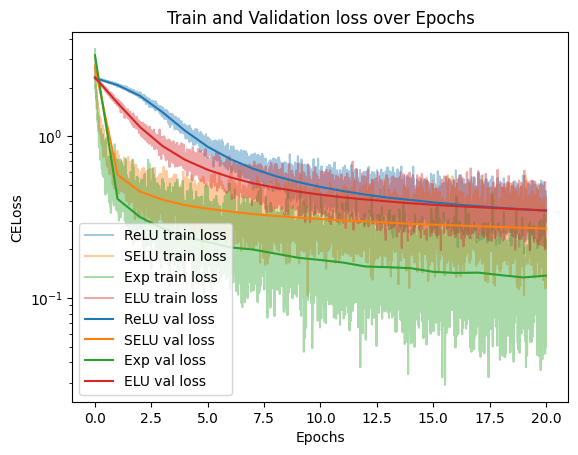

In [15]:
plt.figure()
plt.plot(np.asarray(range(len(rtl))) / len(trainloader), rtl, alpha=0.4, label="ReLU train loss")
plt.plot(np.asarray(range(len(stl))) / len(trainloader), stl, alpha=0.4, label="SELU train loss")
plt.plot(np.asarray(range(len(softtl))) / len(trainloader), softtl, alpha=0.4, label="Exp train loss")
plt.plot(np.asarray(range(len(elutl))) / len(trainloader), elutl, alpha=0.4, label="ELU train loss")
plt.plot(range(len(rvl)), rvl, color="C0", label="ReLU val loss")
plt.plot(range(len(svl)), svl, color="C1", label="SELU val loss")
plt.plot(range(len(softvl)), softvl, color="C2", label="Exp val loss")
plt.plot(range(len(eluvl)), eluvl, color="C3", label="ELU val loss")
plt.title("Train and Validation loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("CELoss")
plt.yscale("log")
plt.legend()
plt.show()

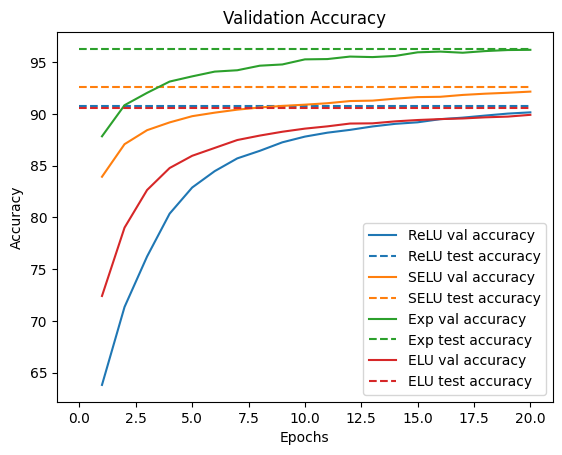

In [16]:
plt.figure()
plt.plot(range(1, len(raccs)+1), [a*100 for a in raccs], label="ReLU val accuracy")
plt.hlines(y=racc*100, xmin=0, xmax=len(raccs), colors="C0", linestyles="dashed", label="ReLU test accuracy")
plt.plot(range(1, len(saccs)+1), [a*100 for a in saccs], label="SELU val accuracy")
plt.hlines(y=sacc*100, xmin=0, xmax=len(saccs), colors="C1", linestyles="dashed", label="SELU test accuracy")
plt.plot(range(1, len(softaccs)+1), [a*100 for a in softaccs], label="Exp val accuracy")
plt.hlines(y=softacc*100, xmin=0, xmax=len(softaccs), colors="C2", linestyles="dashed", label="Exp test accuracy")
plt.plot(range(1, len(eluaccs)+1), [a*100 for a in eluaccs], label="ELU val accuracy")
plt.hlines(y=eluacc*100, xmin=0, xmax=len(eluaccs), colors="C3", linestyles="dashed", label="ELU test accuracy")

plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.legend()
plt.show()